<a href="https://colab.research.google.com/github/praveenjune17/Neural-Machine-Translation-English-Tamil-model/blob/master/eng_tam_nmt_using_Glove_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from requests import get  # to make GET request
import numpy as np
from __future__ import absolute_import, division, print_function, unicode_literals
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import unicodedata
import re
import numpy as np
import os
import io
import time
import random
#!pip install tensorflow-gpu==2.0.0-beta1
!pip install tensorflow-gpu
!pip install -U tf-nightly-gpu
import tensorflow as tf
#tf.random.set_random_seed(1234)
tf.enable_eager_execution()

Requirement already up-to-date: tf-nightly-gpu in /usr/local/lib/python3.6/dist-packages (1.15.0.dev20190628)


In [0]:
download_link = 'http://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip'

In [0]:
def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

In [0]:
start=time.time()
download(download_link, file_name='/content/glove_300d.zip')
print('took {} seconds'.format(time.time()-start)) #56.25 secs
!unzip glove_300d.zip

In [0]:
!unzip en_tam_parrallel_text_nodups_sorted_eng_tam_reversed.zip

###  Analyse input_lang keys :- words in the dictonary with glove vector words , notedown down the words in corpus that is not in the glove vector make the unkown words in glove as <UNK>

In [0]:

# embedding_encoder = tf.get_variable(name="Word_embedding", 
#                                  shape=[24,100], 
#                                  initializer=tf.constant_initializer(np.array(load_embedding_matrix)), 
#                                  trainable=False
#                                 )
# encoder_emb_inp= tf.nn.embedding_lookup(embedding_encoder,x)
# encoder_emb_inp #new input instead of x

In [0]:
path_to_file = '../content/en_tam_parrallel_text_nodups_sorted_eng_tam_reversed.txt'
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w,language='tamil'):
    #w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    if language=='english':
      w = unicode_to_ascii(w.lower().strip())
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
      w = re.sub(r"[^a-zA-Z?.'!]+", " ", w)
    else:
     
      w = re.sub(r"([?.!,¿])", r" \1 ", w.strip())
      w = re.sub(r'[" "]+', " ", w)
      w = re.sub('[a-zA-Z?.!]+', " ", w) #replace english alphabets in tamil sentence
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
 # 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, TAMIL]
def create_dataset(path,start,stop):
  ex1=[]
  ex2=[]
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  for l in lines[start:stop]:
    
    eng,ta= (l.split('\t'))
    ex1.append(preprocess_sentence(eng,language='english'))
    ex2.append(preprocess_sentence(ta,language='tamil'))
    

  return zip(*list(zip(ex1,ex2)))

def remove_extra(input_tensor,target_tensor,threshold):
  


  new_input_tensor = []
  new_target_tensor=[]
  
  for i,j in zip(input_tensor,target_tensor):
    if (len(i) <= threshold) and (len(j) <= threshold):
      new_input_tensor.append(i)
      new_target_tensor.append(j)
      
    
  return(new_input_tensor,new_target_tensor)

def max_length(tensor):
  return max(len(t) for t in tensor)

def tokenize(inp_lang,targ_lang):
  inp_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  inp_lang_tokenizer.fit_on_texts(inp_lang)

  ip_tensor = inp_lang_tokenizer.texts_to_sequences(inp_lang)          #convert the words to numbers of varying lengths
  
  targ_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  targ_lang_tokenizer.fit_on_texts(targ_lang)

  tar_tensor = targ_lang_tokenizer.texts_to_sequences(targ_lang)          #convert the words to numbers of varying lengths
  #ip_tensor,tar_tensor = remove_long_sentence(ip_tensor,tar_tensor,threshold)
  #ip_tensor = tf.keras.preprocessing.sequence.pad_sequences(ip_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                         #padding='post')
  #tar_tensor = tf.keras.preprocessing.sequence.pad_sequences(tar_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                         #padding='post')
  

  return ip_tensor,inp_lang_tokenizer,tar_tensor,targ_lang_tokenizer

def load_dataset(path, start,stop):
    # creating cleaned input, output pairs
    inp_lang,targ_lang  = create_dataset(path, start,stop)
    
    
    
    
    input_tensor, inp_lang_tokenizer, target_tensor, targ_lang_tokenizer = tokenize(inp_lang,targ_lang)
    unk_id = list(inp_lang_tokenizer.word_index.values())[-1] + 1
    inp_lang_tokenizer.word_index['<UNK>'] = unk_id
    inp_lang_tokenizer.index_word[unk_id]  = '<UNK>'
    #target_tensor, targ_lang_tokenizer = tokenize(targ_lang,threshold=threshold)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, unk_id

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang,unk_id = load_dataset(path_to_file, start=160970,stop=228700)

In [0]:

#load glove or any word embedding

def word_embedding_matrix(embedding_path,dim):
    
    #first and second vector are pad and unk words
    
    #with open(embedding_path,'r') as f:
    embeddings = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
      for line in f:
        values = line.strip().split()
        w = values[0]
        if values[1] in {'.', 'Amazon.com', 'Killerseats.com', 'mylot.com', 'name@domain.com'}:
          continue
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings[w] = vectors
      vocab_dict = inp_lang.word_index
      vocab_size = len(vocab_dict)+1
      embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, dim))
      num_loaded = 0
      for w, i in vocab_dict.items():
          v = embeddings.get(w,)
          if v is not None and i < vocab_size:
              embedding_matrix[i] = v
              num_loaded += 1
   
      embedding_matrix = embedding_matrix.astype(np.float32)
      return embedding_matrix
                
        
    #return {'word_vocab': word_vocab,'Embedding_matrix': np.reshape(embedding_matrix,[-1,dim]).astype(np.float32)}

In [0]:

#vocab = inp_lang.word_index.keys

In [0]:
#print(word_embedding_matrix('./glove.840B.300d.txt',vocab[2:],100)['Embedding_matrix'][2]) #vocab 0 and 1 are start and end tokens
import time
start = time.time()
load_embedding_matrix = word_embedding_matrix('./glove.840B.300d.txt',300)
time.time()-start
#load_embedding_matrix = matrix['Embedding_matrix']
#shape_word_vocab      = matrix['word_vocab']

141.64741444587708

In [0]:

# embedding_encoder = tf.get_variable(name="Word_embedding", 
#                                  shape=[24,100], 
#                                  initializer=tf.constant_initializer(np.array(load_embedding_matrix)), 
#                                  trainable=False
#                                 )
# encoder_emb_inp= tf.nn.embedding_lookup(embedding_encoder,x)
# encoder_emb_inp #new input instead of x

In [0]:
# Calculate max_length of the target tensors
prev_ip = len(input_tensor)
prev_tar = len(target_tensor)
input_tensor,target_tensor = remove_extra(input_tensor,target_tensor,threshold=16)
after_ip = len(input_tensor)
after_tar = len(target_tensor)

print('{} and {} sentences removed from ip and target tensor after filtering by threshold'.format((prev_ip-after_ip),(prev_tar-after_tar)))
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                        padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                        padding='post')
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print(max_length_targ)
print(max_length_inp)

11957 and 11957 sentences removed from ip and target tensor after filtering by threshold
16
16


In [0]:
# Creating training and validation sets using an 99-2 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.02)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(54657, 54657, 1116, 1116)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [0]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
14 ----> he
21283 ----> proposes
10 ----> a
704 ----> society
13 ----> that
23 ----> i
232 ----> cannot
807 ----> accept
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
3150 ----> என்னால்
3542 ----> ஏற்றுக்கொள்ள
583 ----> முடியாத
4 ----> ஒரு
47326 ----> சமூகத்தினை
12 ----> அவர்
9092 ----> ஆலோசனை
1105 ----> செய்கிறார்
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(64), Dimension(16)]),
 TensorShape([Dimension(64), Dimension(16)]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                      embeddings_initializer=tf.constant_initializer(np.array(embedding_matrix)))
    self.gru_fw = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform')
    self.bi_gru=tf.keras.layers.Bidirectional(self.gru_fw,merge_mode='ave')
    

  def call(self, x, hidden1,hidden2):    
    x = self.embedding(x)
    output, fw_state, bk_state = self.bi_gru(x, initial_state = [hidden1,hidden2])
    state = tf.math.add(fw_state,bk_state)/2    
    return output, state
 

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE,load_embedding_matrix)
sample_hidden1 = encoder.initialize_hidden_state()
sample_hidden2 = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden1,sample_hidden2)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    #self.dec_units = dec_units*2  #Since bidirectional RNN has concatenated cells 
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    


    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, state,attention_weights = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 91934)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden_fw,enc_hidden_bk):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden_fw,enc_hidden_bk)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
      
  
  batch_loss = (loss / int(targ.shape[1]))
  
  variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, variables)
  
  optimizer.apply_gradients(zip(gradients, variables))
  
  return batch_loss

In [0]:
EPOCHS = 2

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden_fw = encoder.initialize_hidden_state()
  enc_hidden_bk = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden_fw,enc_hidden_bk)
  
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  #if (epoch + 1) % 2 == 0:
  checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8970
Epoch 1 Batch 100 Loss 0.7762
Epoch 1 Batch 200 Loss 0.7781
Epoch 1 Batch 300 Loss 0.8510
Epoch 1 Batch 400 Loss 0.9216
Epoch 1 Batch 500 Loss 0.8284
Epoch 1 Batch 600 Loss 0.8474
Epoch 1 Batch 700 Loss 0.7821
Epoch 1 Batch 800 Loss 0.8915
Epoch 1 Loss 0.8326
Time taken for 1 epoch 972.3745691776276 sec

Epoch 2 Batch 0 Loss 0.8241


KeyboardInterrupt: ignored

In [0]:
def evaluate(sentence,unk_id,sample_size):
  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence,language='english')
    inputs = [inp_lang.word_index.get(i,unk_id) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden1 = tf.zeros((1, units))
    hidden2 = tf.zeros((1, units))
    enc_out, enc_hidden = encoder(inputs, hidden1,hidden2)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        #predicted_id = tf.argmax(predictions[0]).numpy()
        
        #Implement top-n sampling decoding technique
        distribution = tf.argsort(predictions[0],direction='DESCENDING').numpy()[:sample_size]
        #random.seed(2)
        predicted_id = random.choice(distribution)
        
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence,sample_size):
    result, sentence, attention_plot = evaluate(sentence,unk_id,sample_size=sample_size)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).assert_consumed()

In [0]:

def calc_BLEU():
  start=time.time()
  score = 0
  for targ,sour_input in zip(targ_lang.sequences_to_texts(target_tensor_val),inp_lang.sequences_to_texts(input_tensor_val)):
    
      
    sour_input = sour_input.replace('<start>','').replace('<end>','')
    targ = targ.replace('<start>','').replace('<end>','')
    try:
      result,_,_=evaluate(sour_input,unk_id,sample_size=1)
    except KeyError:
      continue
      print(sour_input)
      
    
    score +=sentence_bleu([targ],result)
  print('processing time is {}'.format((time.time()-start)))
  return(score/len(target_tensor_val) )

Input: <start> take sufficient water <end>
Predicted translation: நிச்சயமாக இது தான் ஒருபோதும் கிடையாது என்பதை உறுதி கொண்டிருக்கும் <end> 


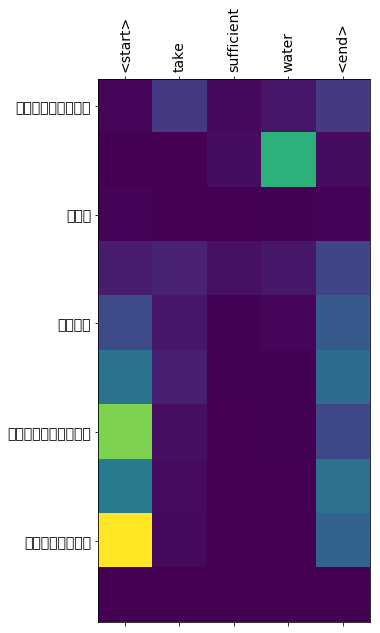

Input: <start> you must specify a folder <end>
Predicted translation: நீங்கள் தொழிலாளர்களுக்கு உங்கள் வாழ்க்கையில் ஒரு தேர்வு செய்ய வேண்டும் என்பதைக் குறிப்பிட இதை உறுதி செய்யப்பட்டார் <end> 


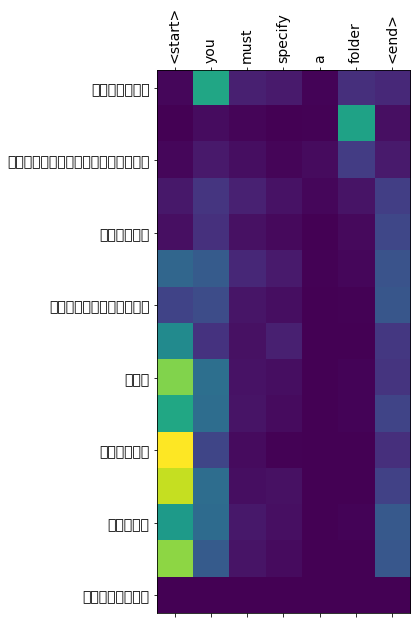

Input: <start> executor of his own will <end>
Predicted translation: நிச்சயமாக இது தான் ஜன்னத்துல் மஃவா என்பதை கவனிக்கட்டும் <end> 


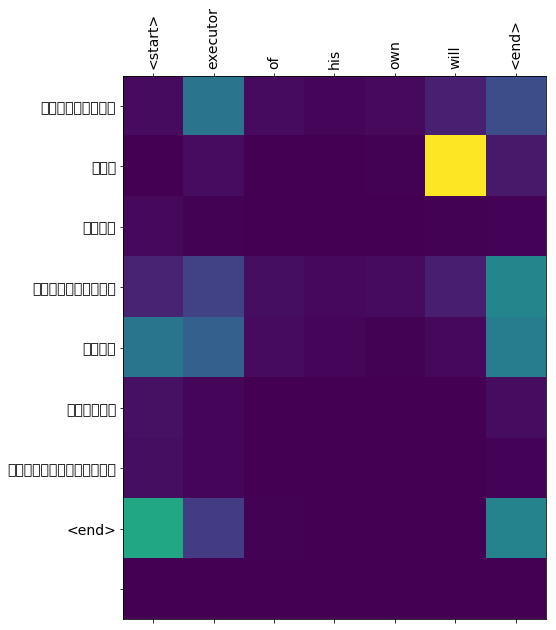

Input: <start> this will keep getting better <end>
Predicted translation: ஆனால் , அவர் , இரண்டு உண்மைகளை கட்டப்பட்ட தள்ளப்படும் பிளாஸ்மா ஆராயும் ஆராயும் வடிவியல் செய்தி அனுப்புகிறது போல இருக்கிறதா 


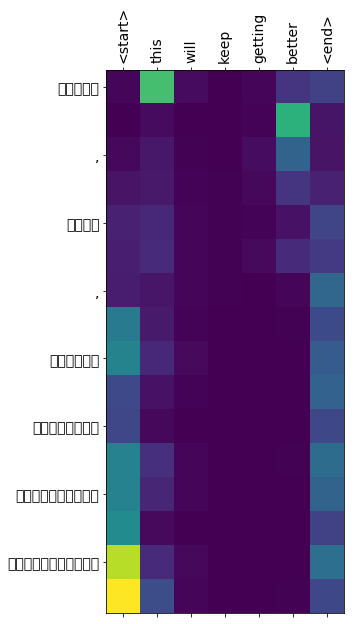

Input: <start> sorry for confusing you <end>
Predicted translation: நான் உங்கள் கால் தெளிவான திருக்குர்ஆனுடையவுமான வசனங்களாகும் , <end> 


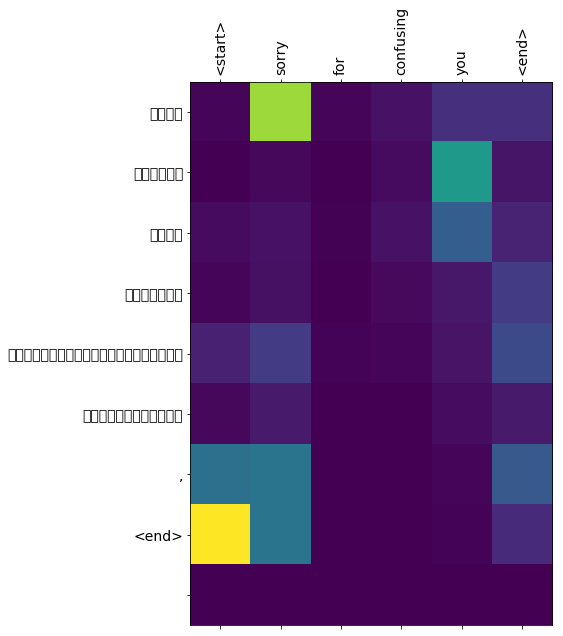

Input: <start> hey who are you man ? <end>
Predicted translation: நான் உன்னை நாம் ஒரு பயங்கர சுனாமி எச்சரிக்கை செய்வீராக , என்னிடம் கொண்டு , <end> 


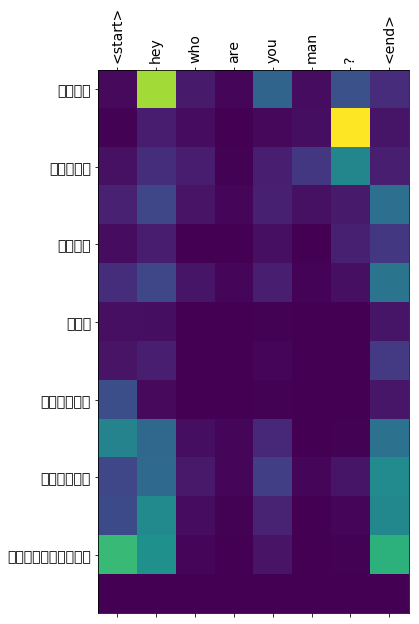

Input: <start> message from server <end>
Predicted translation: இந்த ஆவணம் சேமிக்கப்படவில்லை <end> 


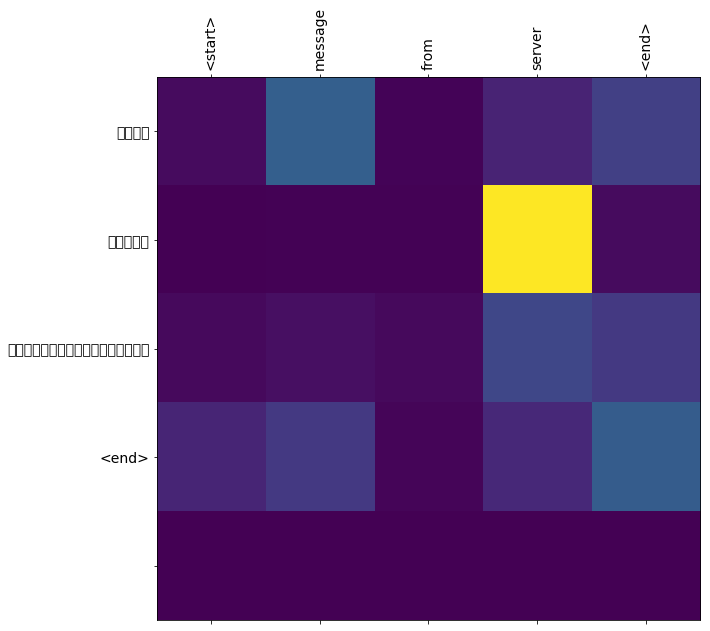

Input: <start> i have three sons <end>
Predicted translation: நான் வின்சென்ட் ஸ்வான்னோட பட்டினி , நான் தெஹிவலையில் மீது அழகான கலசம் கூறுகிறோம் , <end> 


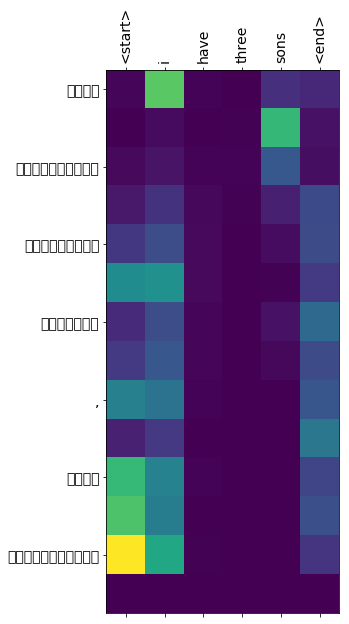

Input: <start> you work well only with long sentence <end>
Predicted translation: நீங்கள் அனைத்து நூலகங்களும் நிரல்களும் நிறுவப்படவில்லை <end> 


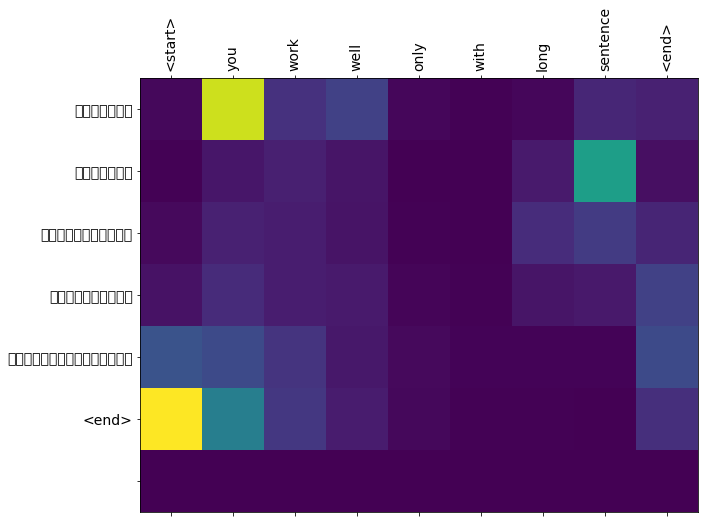

Input: <start> there is a mark on the ruler <end>
Predicted translation: மரங்கள் பல்வேறுபட்ட செயல்களுக்கான இனவாத யுத்தத்தைத் தவிர <end> 


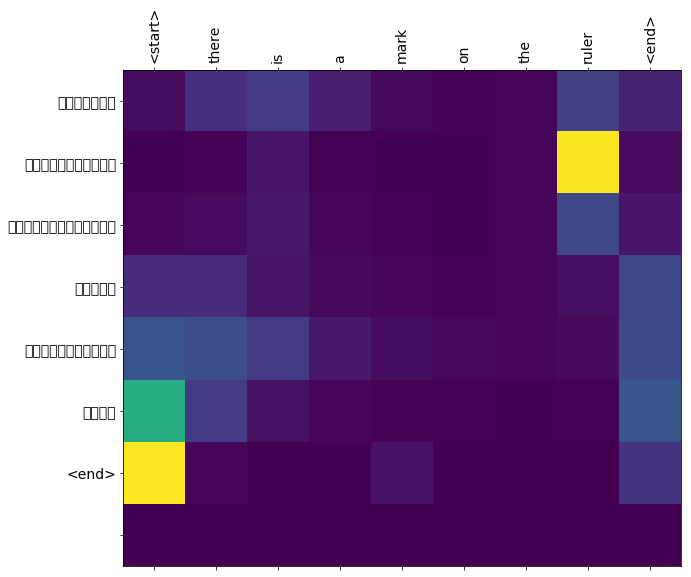

Input: <start> shooting in america <end>
Predicted translation: திரைப்படத்தின் மூலம் ராமநாதன் டிசம்பர் வெளியீடு <end> 


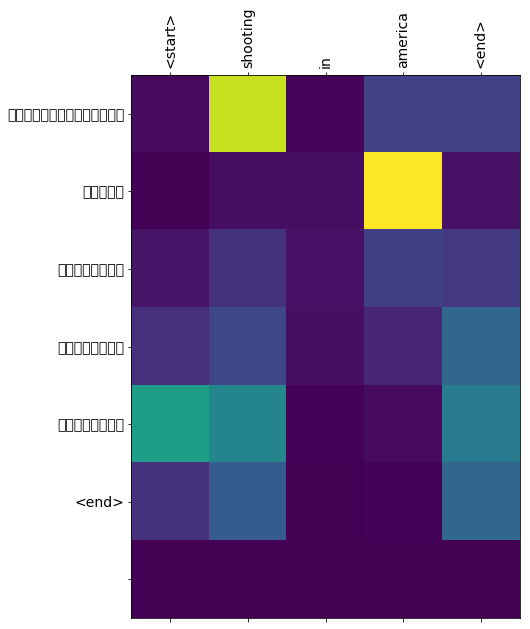

Input: <start> and i hate pepperoni <end>
Predicted translation: மூச்சுத்திணற விட்டும் , ஒருவரை , (நீர்) அதை ஏற்றுவிடுமா என்பது <end> 


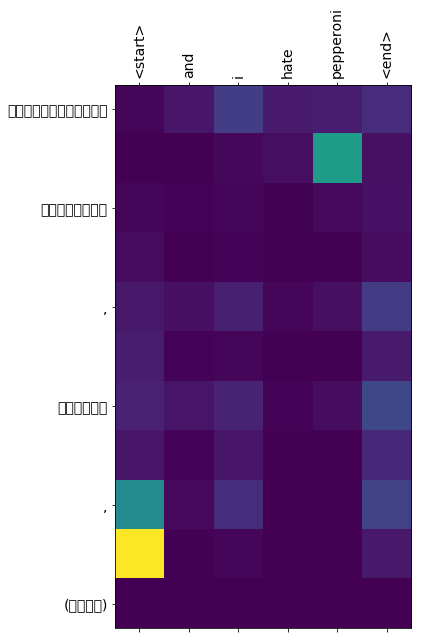

In [0]:
random.seed(2)
n=2
translate(u'take sufficient water',n)
translate(u'You must specify a folder',n)
translate(u'Executor of His own will',n)
translate(u'This will keep getting better',n)
translate(u'Sorry for confusing you',n)
translate(u'Hey, who are you man?',n)
translate(u'Message from server',n)
translate(u"I have three sons",n)
translate(u'you work well only with long sentence',n)
translate(u'there is a mark on the ruler',n)
translate(u'Shooting in America',n)
translate(u'And I hate pepperoni',n)

Input: <start> all right look we're not going to let a couple of seagulls ruin our moment <end>
Predicted translation: நாம் தாம் தான் என்னை அவர் குடும்பத்தாரையும் யாவரையும் காத்துக் கொண்டோம் <end> 


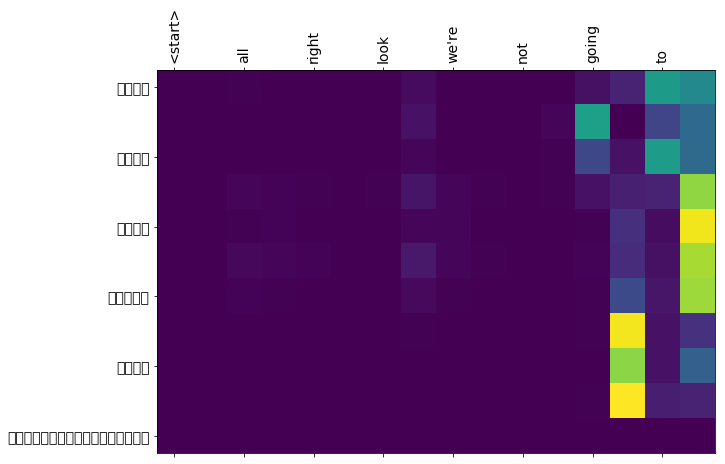

In [0]:
translate("All right, look, we're not going to let a couple of seagulls ruin our moment",1)

In [0]:
#0.18410697440308754
Bleu_score = calc_BLEU()
print(Bleu_score)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
